# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 04 Spectral subtraction, Wiener filtering, end point detectoin, voice activity detection
2023/04/07

----
### import packages, define analysis parameters and draw parameters, etc.

In [50]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
from scipy.signal import stft, istft, welch
import scipy

# save the sound file
import soundfile as sf

# display wav files
import IPython

In [30]:
import os

if not os.path.exists('out'):
    os.makedirs('out')

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

---
### load speech and noise

오디오 파일들의 경로 정의

In [5]:
audioinputpath = '../audio'
outpath = 'out'

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

다음의 두 개의 파일을 이용하여 speech 와 noise의 특성을 비교하여 본다.

In [6]:
speechfile = addpath(audioinputpath, 'gjang-kdigits0-3.wav')
noisefile  = addpath(audioinputpath, 'car.wav')

__load files in windows wav format__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [7]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono=True)
noise, _ = librosa.load(noisefile, sr=Fs, mono=True)
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speechfile, speech.shape, speech)
print(noisefile, noise.shape, noise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/gjang-kdigits0-3.wav (37952,) [-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04]
../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  0.98169835, -48.88611563,   3.1324693 , ...,  -9.12823462,
          2.7801733 ,   1.09309141],
       [ 15.65259614,  16.00577403,  16.22904319, ...,  13.82631938,
         15.76671355,  17.55505021],
       [ 15.55749858,  17.52033179,  17.45295515, ...,  18.98548141,
         19.86723635,  19.6122841 ],
       ...,
       [-68.11610281, -60.06479629, -62.70839477, ..., -49.39283694,
        -45.83500294, -56.26431093],
       [-54.83801771, -52.36526795, -56.37173569, ..., -50.60357958,
        -46.87544314, -60.39318112],
       [-66.43200604, -53.80243152, -73.95182647, ..., -48.89061985,
        -46.85413105, -52.25941962]])

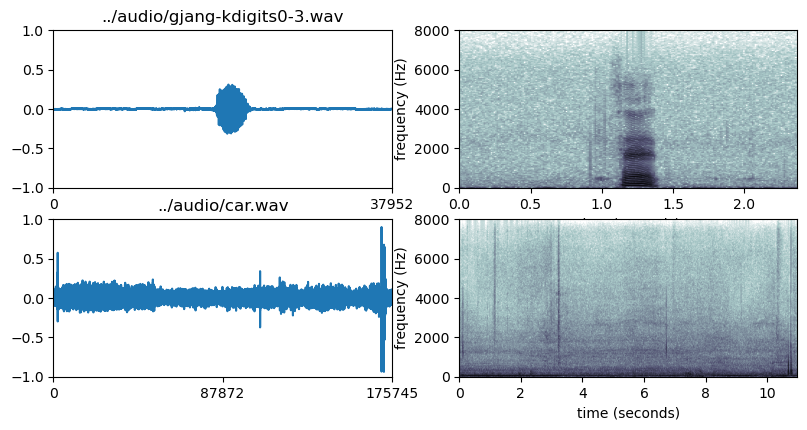

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.2,1.5]))
plt.subplot(2,2,1)
plt.plot(speech); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
plt.title(speechfile)
plt.subplot(2,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)
plt.subplot(2,2,3)
plt.plot(noise); plt.xlim(0,len(noise)); plt.ylim(-1,1); plt.xticks([0, len(noise)//2, len(noise)])
plt.title(noisefile)
plt.subplot(2,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.

__noise gain adjustment to match the targer SNR__

1. 음성과 잡음의 상대적 크기는 SNR (signal-to-noise ratio)로 정의할 수 있다.
$$ SNR = 20 \log_{10} \frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2}[t]}} 
= 10 \log_{10} \frac{\sum_{t=1}^{T} s^2[t]}{\sum_{t=1}^{T} n^{2}[t]} 
= 10 \log_{10} \frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} }
$$
> integer index $t$ 는 sample index, $\langle \cdot \rangle_{T}$ 은 $T$개의 sample mean 을 나타낸다.
2. speech 와 noise 를 다음과 같이 normalize 한다.
$$ \sigma_{s} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} s^{2} [t] } , \quad s_{\sigma = 1} [t] = \frac{s[t]}{\sigma_{s}} , 
\quad \sigma_{n} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2} [t] } , \quad n_{\sigma = 1} [t] = \frac{n[t]}{\sigma_{n}}$$
3. target SNR $r$ 에 맞추기 위한 gain 계산
$$ SNR_{\sigma=1} = 10 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 10 \log_{10} \frac{1}{1} = 0 $$
$$ \Rightarrow r = r + SNR_{\sigma=1} 
= 10 \log_{10} 10^{r/10} + 10 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
$$
$$ = 10 \log_{10} 10^{r/10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
= 10 \log_{10} 10^{r/10} \cdot \left\{ \frac{1/\sigma_{s}}{1/\sigma_{n}} \right\}^2
\frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} } $$
$$ = 10 \log_{10} 10^{-r/10} \left\{ \frac{\sigma_{s}}{\sigma_{n}} \right\}^2
\langle n^2 \rangle_{T} +  10 \log_{10} \langle s^2 \rangle_{T} $$
- 따라서 다음의 치환에 의해 target SNR $r$ 에 맞출 수 있다.
$$ n[t] \Leftarrow \sqrt{10^{-r/10}} \frac{\sigma_{s}}{\sigma_{n}} n[t] = 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00


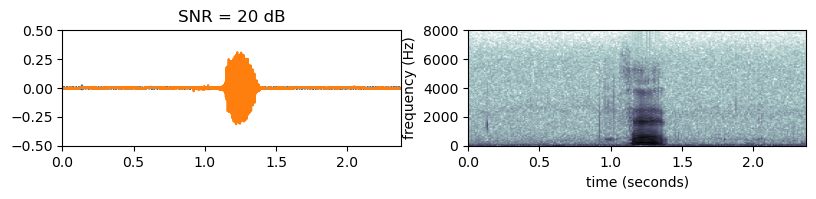

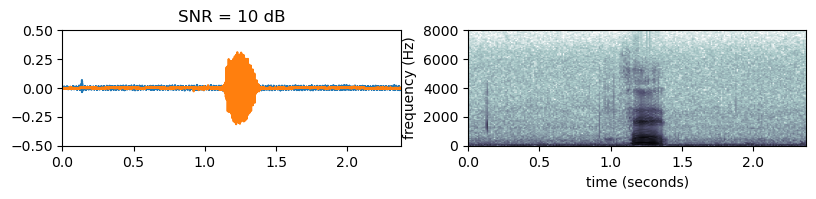

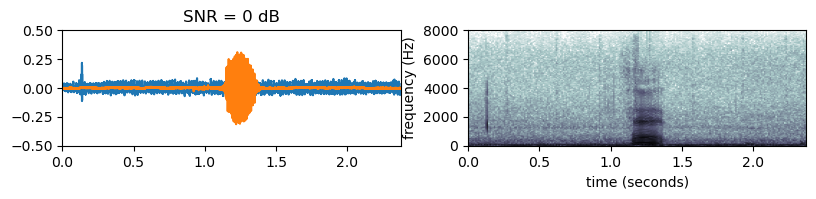

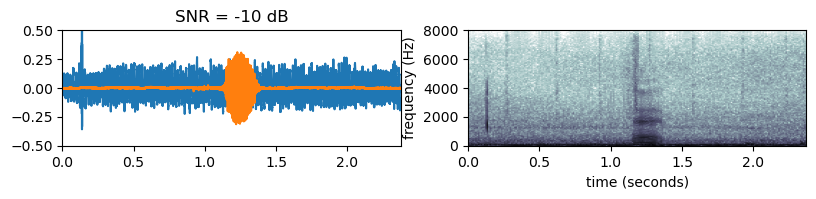

In [31]:
import gjwavfile as wav

std_s = np.sqrt(np.mean(speech**2))
std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
mixsnrs = np.array([20, 10, 0, -10])
mixedSig = []
mixedWavfiles = []
for snr in mixsnrs:
    #gain = np.sqrt(np.power(10, -snr/10))
    gain = np.power(10, -snr/20)
    gn = noise[:len(speech)]/std_n*std_s*gain
    m = speech + gn
    mixedSig.append(m)
    print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))
    
    # draw
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
    plt.subplot(1,2,1)
    xscale = np.arange(len(gn))/Fs
    plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
    plt.title('SNR = %.0f dB' % (snr))
    plt.subplot(1,2,2)
    drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)
    
    # save the mixed file
    fname = addpath(outpath, 'mix%.fdb.wav' % (snr))
    # wav.writewav(fname, Fs, m, maxval=1.0)
    sf.write(fname, m, Fs)
    mixedWavfiles.append(fname)

In [ ]:
IPython.display.Audio(mixedWavfiles[0])

In [ ]:
IPython.display.Audio(mixedWavfiles[1])

In [ ]:
IPython.display.Audio(mixedWavfiles[2])

In [ ]:
IPython.display.Audio(mixedWavfiles[3])

- 입력 음성 파일에 무음구간이 워낙 많기 때문에 음성이 상대적으로 크게 들린다. 원래 0 dB 에서는 크기가 거의 같아야 한다.
- 제대로 SNR 을 측정하기 위해서는 음성과 잡음의 무음 구간을 고려해야 한다.

Target SNR = -5 dB, gain = 1.78, Mixing SNR (whole interval) =-13.82


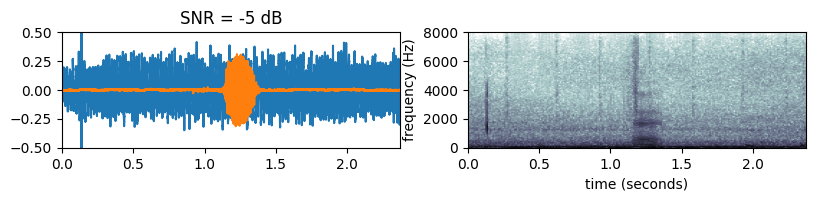

In [ ]:
# 음성 존재구간을 tight 하게 잡고(1.1-1.4 sec) SNR = -5 dB 로 합성
tightinterval = (np.array([1.1, 1.4])*Fs).astype(int)
ss = speech[tightinterval[0]:tightinterval[1]]
nn = noise[tightinterval[0]:tightinterval[1]]
std_s = np.sqrt(np.mean(ss**2))
std_n = np.sqrt(np.mean(nn**2))
snr = -5
gain = np.sqrt(np.power(10, -snr/10))
gn = noise[:len(speech)]/std_n*std_s*gain
m = speech + gn
print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR (whole interval) =%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))

# draw
plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
xscale = np.arange(len(gn))/Fs
plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
plt.title('SNR = %.0f dB' % (snr))
plt.subplot(1,2,2)
_ = drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

# save the mixed file
fname = addpath(outpath, 'mixtight%.fdb.wav' % (snr))
wav.writewav(fname, Fs, m, maxval=1.0)
mixedWavfiles.append(fname)

In [ ]:
IPython.display.Audio(mixedWavfiles[-1])

---
## Programming assignments: spectral subtraction and Wiener filtering, end point detectoin

1. 각각의 SNR에 대해서 잡음을 앞의 0.5 초 구간에서 추정하고 이를 차감하는 FIR 필터를 적용하여 잡음을 제거한다.
2. energy 기반 end point detectoin 을 구현한다. 
3. end point detection 으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.

In [ ]:
### Assignments

1. 각각의 SNR에 대해서 잡음을 앞의 0.5 초 구간에서 추정하고 이를 차감하는 FIR 필터를 적용하여 잡음을 제거한다.

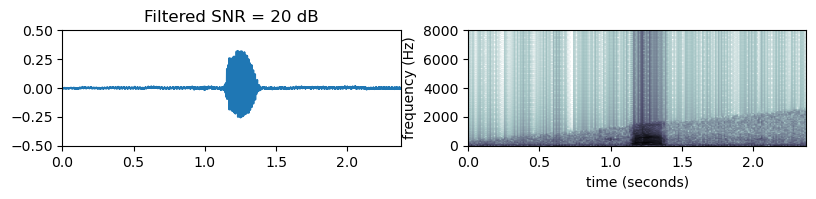

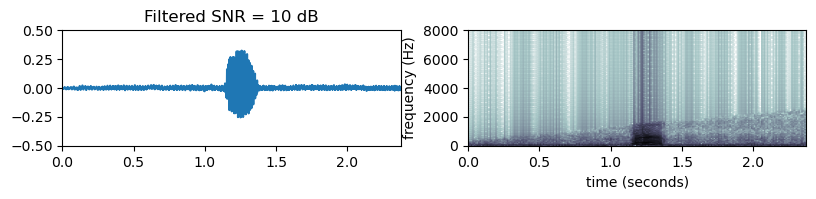

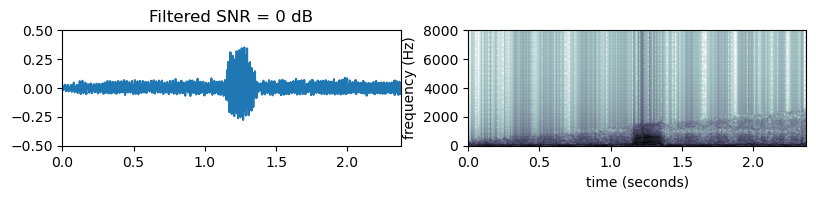

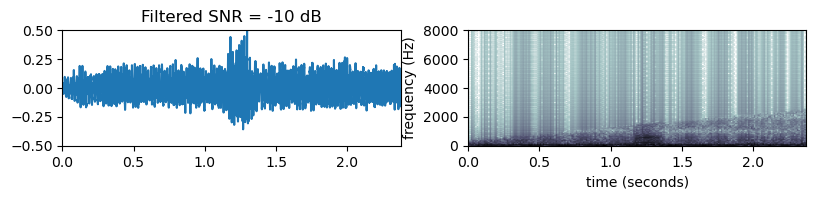

In [34]:
# Define a function to create a lowpass FIR filter with a linearly increasing cutoff frequency
def create_lowpass_filter(order, cutoff_freq, Fs):
    nyquist = 0.5 * Fs
    normalized_cutoff = cutoff_freq / nyquist
    b = signal.firwin(order + 1, normalized_cutoff, window='hamming')
    return b

# Define the parameters for the trapezoidal overlap-add method
overlap = 0.003  # 3 ms overlap
N_shift = int(Fs * Ts)  # 10 ms shift
N_overlap = int(Fs * overlap)

filteredSig = []

# Apply the lowpass FIR filter and trapezoidal overlap-add for each SNR
for snr, mixed in zip(mixsnrs, mixedSig):
    # Design the lowpass FIR filter with a linearly increasing cutoff frequency
    filter_order = 127
    cutoff_freq = np.linspace(300, 2500, len(mixed) // N_shift)
    filtered_frames = []

    # Divide the noisy signal into overlapping frames and apply the FIR filter
    for i in range(0, len(mixed) - N_shift, N_shift):
        frame = mixed[i:i + N_shift + N_overlap]
        b = create_lowpass_filter(filter_order, cutoff_freq[i // N_shift], Fs)
        filtered_frame = signal.lfilter(b, 1, frame)
        filtered_frames.append(filtered_frame)

    # Perform the trapezoidal overlap-add to reconstruct the filtered signal
    filtered = np.zeros(len(mixed))
    for i, frame in enumerate(filtered_frames):
        start = i * N_shift
        end = start + len(frame)
        filtered[start:end] += frame

    filteredSig.append(filtered)

    # Plot the waveform and spectrogram of the filtered signal
    plt.figure(figsize=FIG_SIZE*np.array([1.2, 0.5]))
    plt.subplot(1, 2, 1)
    xscale = np.arange(len(filtered)) / Fs
    plt.plot(xscale, filtered)
    plt.xlim(0, len(filtered) / Fs)
    plt.ylim(-0.5, 0.5)
    plt.title('Filtered SNR = %.0f dB' % snr)
    plt.subplot(1, 2, 2)
    drawspectrogram3(filtered, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

    # Save the filtered signal as a .wav file
    fname = addpath(outpath, 'filtered_snr_%.0f_db.wav' % snr)
    # wav.writewav(fname, Fs, filtered, maxval=1.0)
    sf.write(fname, filtered, Fs)


In [41]:
# filtered_snr_-10_db.wav

IPython.display.Audio('./out/filtered_snr_-10_db.wav')

In [42]:
# filtered_snr_0_db.wav

IPython.display.Audio('./out/filtered_snr_0_db.wav')

In [43]:
# filtered_snr_10_db.wav

IPython.display.Audio('./out/filtered_snr_10_db.wav')

In [44]:
# filtered_snr_20_db.wav

IPython.display.Audio('./out/filtered_snr_20_db.wav')

In [45]:
# mix-10db.wav

IPython.display.Audio('./out/mix-10db.wav')

In [46]:
# mix0db.wav

IPython.display.Audio('./out/mix0db.wav')

In [47]:
# mix10db.wav

IPython.display.Audio('./out/mix10db.wav')

In [48]:
# mix20db.wav

IPython.display.Audio('./out/mix20db.wav')

2. energy 기반 end point detectoin 을 구현한다.

In [38]:
def energy_based_endpoint_detection(signal, frame_length, frame_shift, energy_threshold):
    # Calculate the energy of the signal
    energy = np.array([
        np.sum(signal[i:i + frame_length] ** 2)
        for i in range(0, len(signal) - frame_length, frame_shift)
    ])

    # Normalize the energy
    energy_normalized = energy / np.max(energy)

    # Detect the start and end points based on the energy threshold
    start = np.where(energy_normalized > energy_threshold)[0][0] * frame_shift
    end = np.where(energy_normalized > energy_threshold)[0][-1] * frame_shift + frame_length

    return start, end

# Example usage
frame_length = int(Fs * 0.02)  # 20 ms
frame_shift = int(Fs * 0.01)  # 10 ms
energy_threshold = 0.1

start, end = energy_based_endpoint_detection(speech, frame_length, frame_shift, energy_threshold)

print(f"Start: {start}, End: {end}")

Start: 18240, End: 21600


3. end point detection 으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.


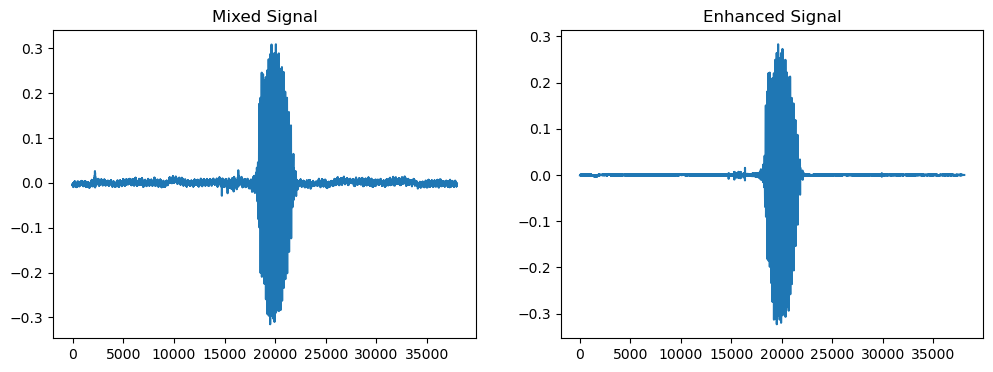

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft, welch

def time_domain_wiener_filter(signal, noise, frame_length, frame_shift):
    # Compute the STFT of the signal and noise
    f, t, Zxx_signal = stft(signal, Fs, nperseg=frame_length, noverlap=frame_length - frame_shift)
    _, _, Zxx_noise = stft(noise, Fs, nperseg=frame_length, noverlap=frame_length - frame_shift)
    
    # Compute the power spectral density (PSD) of the signal and the noise
    signal_psd = np.abs(Zxx_signal)**2
    noise_psd = np.abs(Zxx_noise)**2

    # Compute the Wiener filter
    wiener_filter = signal_psd / (signal_psd + noise_psd)

    # Apply the Wiener filter and compute the inverse STFT to obtain the enhanced signal
    enhanced_Zxx = Zxx_signal * wiener_filter
    _, enhanced_signal = istft(enhanced_Zxx, Fs, nperseg=frame_length, noverlap=frame_length - frame_shift)

    return enhanced_signal

# Example usage
frame_length = Nf
frame_shift = Ns
noise_signal = noise[:len(speech)]
enhanced_speech = time_domain_wiener_filter(mixedSig[0], noise_signal, frame_length, frame_shift)

# Plot the original and enhanced signals
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mixedSig[0])
plt.title("Mixed Signal")
plt.subplot(1, 2, 2)
plt.plot(enhanced_speech)
plt.title("Enhanced Signal")
plt.show()


## End of Lab 04